# K-fold validation 

We have mentioned k-fold validation a few times throughout the exercises.

We split data into a number of 'folds' - let's say 10. This means we have 10 datasets, each with 10% of the data from our whole* dataset in.

We use 90% of the data to train on, and 10% as our validation dataset. 

We record this score, then use a different 10% to score our model on, training our model on the remaining 90%.

We repeat this until every 'fold' has been used as the validation dataset *once*. 

---

Note: Here, we apply k-fold validation **after** splitting out a final testing dataset to use later.

K-fold validation replaces the train/validate data split. 

---

There are various helper functions within sklearn to allow us to undertake k-fold validation.


In [1]:
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, \
                                    StratifiedKFold, KFold
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
try:
    data = pd.read_csv("data/processed_data.csv")

except FileNotFoundError:
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'

    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

data = data.astype(float)

# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

feature_names = X.columns.tolist()

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training/Validation Dataset Samples: {len(X_train_val)}")
print(f"Testing Dataset Samples: {len(X_test)}")

Training/Validation Dataset Samples: 712
Testing Dataset Samples: 179


Now we can use the cross_validate function to set up and score our models. 

It will default to using 'stratified' sampling, where the percentage of samples within each group are kept as consistent as possible across all samples.

In [3]:
model = XGBClassifier(random_state=42)

scores = cross_validate(
    model, X_train_val, y_train_val,
    scoring=['accuracy', 'f1', 'roc_auc', 'precision_macro', 'recall_macro'],
    n_jobs=-1,
    cv=10
    )

scores_df = pd.DataFrame(scores)

<Axes: >

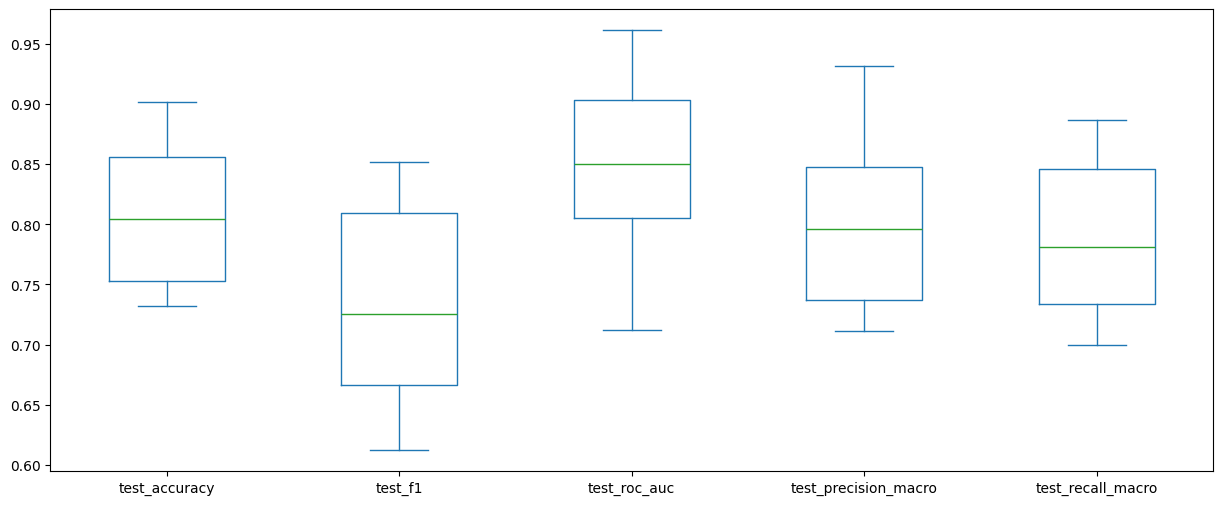

In [4]:
scores_df.drop(columns=["fit_time", "score_time"]).plot(kind="box", figsize=(15, 6))

Let's repeat this with a smaller number of folds. 

In [5]:
model = XGBClassifier(random_state=42)

scores = cross_validate(
    model, X_train_val, y_train_val,
    scoring=['accuracy', 'f1', 'roc_auc', 'precision_macro', 'recall_macro'],
    n_jobs=-1,
    cv=5
    )

scores_df_5_fold = pd.DataFrame(scores)

scores_df_5_fold

,fit_time,score_time,test_accuracy,test_f1,test_roc_auc,test_precision_macro,test_recall_macro
0,0.146062,0.042184,0.797203,0.707071,0.852164,0.791950,0.767894
1,0.195811,0.051646,0.797203,0.743363,0.847170,0.784504,0.793383
2,0.244153,0.046421,0.845070,0.784314,0.882552,0.838271,0.826797
3,0.241028,0.049274,0.816901,0.754717,0.862943,0.804325,0.804325
4,0.261768,0.046865,0.816901,0.754717,0.854167,0.806838,0.802189


<Axes: >

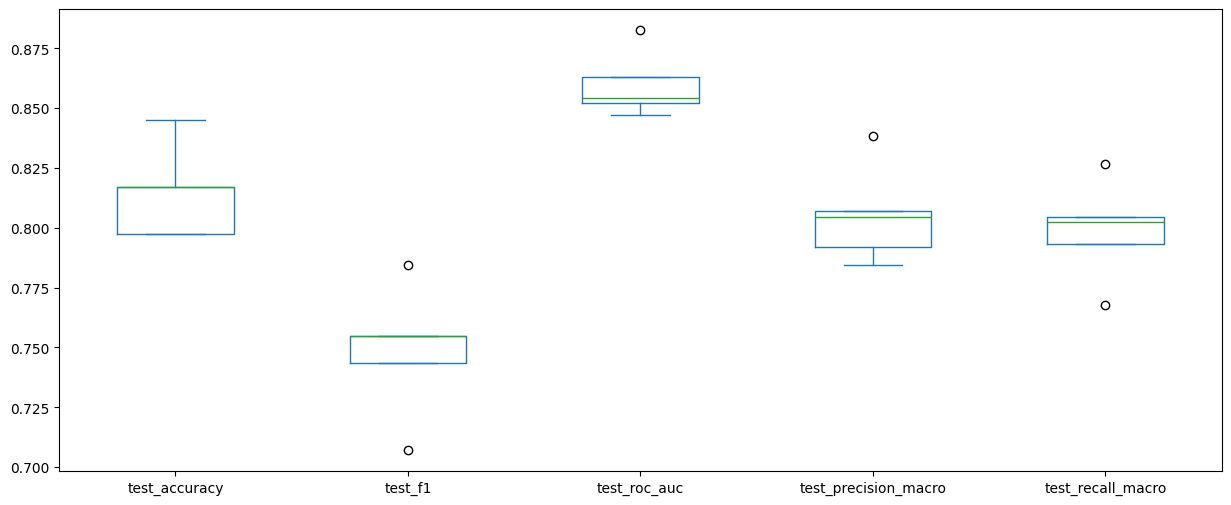

In [6]:
scores_df_5_fold.drop(columns=["fit_time", "score_time"]).plot(kind="box", figsize=(15, 6))

Let's compare what we see.

test_accuracy              Axes(0.125,0.11;0.133621x0.77)
test_f1                 Axes(0.285345,0.11;0.133621x0.77)
test_precision_macro     Axes(0.44569,0.11;0.133621x0.77)
test_recall_macro       Axes(0.606034,0.11;0.133621x0.77)
test_roc_auc            Axes(0.766379,0.11;0.133621x0.77)
dtype: object

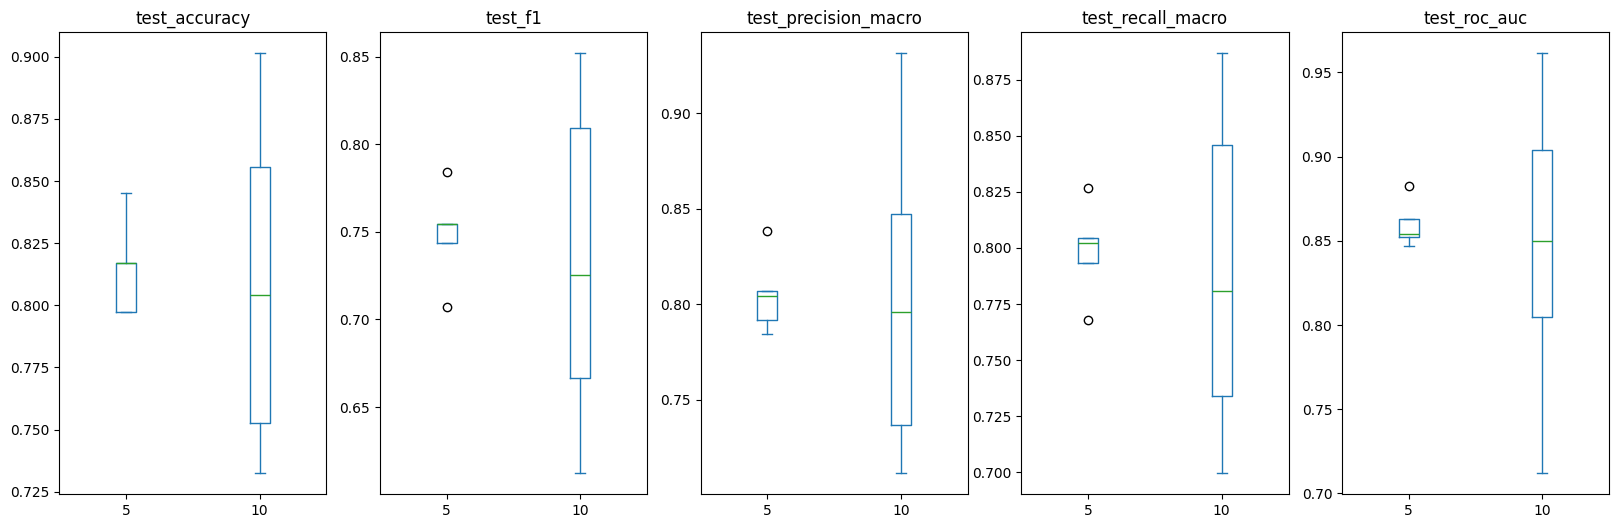

In [7]:
scores_df_5_fold['folds'] = 5
scores_df['folds'] = 10

pd.concat([scores_df_5_fold, scores_df]).drop(columns=["fit_time", "score_time"]).plot(
    kind="box", figsize=(20, 6), by='folds'
    )


Roughly how many datapoints do we get in our validation portion of the dataset when we do this?

In [8]:
len(X_train_val) / 10

71.2

Roughly how many examples of each class would there be in our resulting datasets? 

In [9]:
y_train_val.value_counts()/10

0.0    44.4
1.0    26.8
Name: Survived, dtype: float64

Let's compare this with 5-fold validation.

In [10]:
len(X_train_val) / 5

142.4

In [11]:
y_train_val.value_counts()/5

0.0    88.8
1.0    53.6
Name: Survived, dtype: float64

# Prediction

We can still create predictions when using cross validation.

In [12]:
y_pred_10 = cross_val_predict(
    model,
    X_train_val,
    y_train_val,
    cv=10,
)

y_pred_5 = cross_val_predict(
    model,
    X_train_val,
    y_train_val,
    cv=5,
)

This allows us to create outputs like confusion matrices.

Text(0.5, 1.0, '5-fold CV')

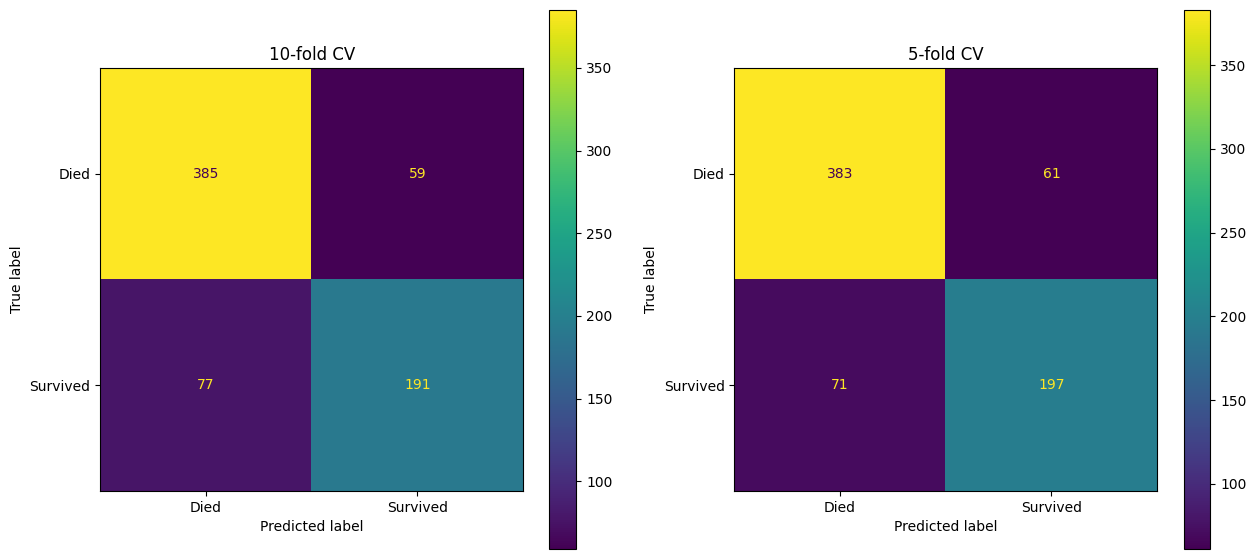

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

confusion_matrix_10 = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_true=y_train_val,
        y_pred=y_pred_10
        ),
        display_labels=["Died", "Survived"]

)

confusion_matrix_10.plot(ax=ax1)
ax1.set_title("10-fold CV")

confusion_matrix_5 = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_true=y_train_val,
        y_pred=y_pred_5
        ),
        display_labels=["Died", "Survived"]

)

confusion_matrix_5.plot(ax=ax2)
ax2.set_title("5-fold CV")

Note the slight variation in performance here.

We can also generate performance reports.

In [14]:
pd.DataFrame(
    classification_report(y_train_val, y_pred_5, output_dict=True)
).round(3)

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.844,0.764,0.815,0.804,0.813
recall,0.863,0.735,0.815,0.799,0.815
f1-score,0.853,0.749,0.815,0.801,0.814
support,444.000,268.000,0.815,712.000,712.000


# Further Control

By setting up the KFold validation ourselves, we can have further control over the process.

Here, we are going to ensure the data is shuffled before use, and set a random seed so the process is replicable.

In [15]:
scores = cross_validate(
    model, X_train_val, y_train_val,
    scoring=['accuracy', 'f1', 'roc_auc', 'precision_macro', 'recall_macro'],
    n_jobs=-1,
    cv=StratifiedKFold(5, shuffle=True, random_state=42)
    )

scores_df_5_fold_shuffled_42 = pd.DataFrame(scores)

scores_df_5_fold_shuffled_42

,fit_time,score_time,test_accuracy,test_f1,test_roc_auc,test_precision_macro,test_recall_macro
0,1.316582,0.346691,0.783217,0.704762,0.831149,0.770354,0.763941
1,3.018813,0.269090,0.874126,0.823529,0.898772,0.874342,0.855181
2,1.302990,0.355363,0.823944,0.757282,0.853297,0.813913,0.806127
3,0.987926,0.197368,0.781690,0.704762,0.837821,0.766880,0.764787
4,0.566683,0.074188,0.830986,0.750000,0.828283,0.838571,0.799242


Let's take a look at the impact of changing the random seed.

In [16]:
scores = cross_validate(
    model, X_train_val, y_train_val,
    scoring=['accuracy', 'f1', 'roc_auc', 'precision_macro', 'recall_macro'],
    n_jobs=-1,
    cv=StratifiedKFold(5, shuffle=True, random_state=101)
    )

scores_df_5_fold_shuffled_102 = pd.DataFrame(scores)

scores_df_5_fold_shuffled_102

,fit_time,score_time,test_accuracy,test_f1,test_roc_auc,test_precision_macro,test_recall_macro
0,0.221575,0.176622,0.776224,0.698113,0.815543,0.762363,0.758323
1,1.539527,0.315225,0.825175,0.752475,0.866729,0.820922,0.801290
2,1.212714,0.612245,0.760563,0.679245,0.810473,0.744117,0.744117
3,1.664313,0.329696,0.802817,0.740741,0.896544,0.788924,0.793089
4,1.536362,0.269400,0.838028,0.772277,0.872475,0.835946,0.815657


test_accuracy              Axes(0.125,0.11;0.133621x0.77)
test_f1                 Axes(0.285345,0.11;0.133621x0.77)
test_precision_macro     Axes(0.44569,0.11;0.133621x0.77)
test_recall_macro       Axes(0.606034,0.11;0.133621x0.77)
test_roc_auc            Axes(0.766379,0.11;0.133621x0.77)
dtype: object

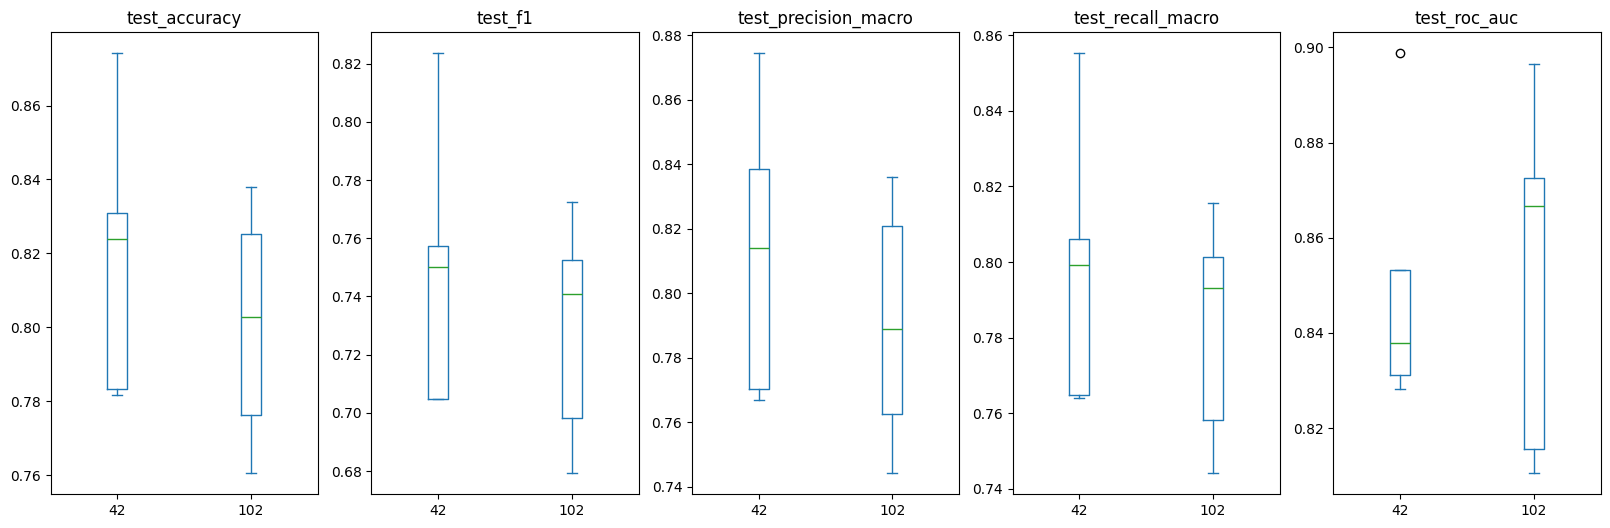

In [17]:
scores_df_5_fold_shuffled_42['seed'] = 42
scores_df_5_fold_shuffled_102['seed'] = 102

pd.concat([scores_df_5_fold_shuffled_42,scores_df_5_fold_shuffled_102]) \
    .drop(columns=["fit_time", "score_time"]) \
    .plot(kind="box", figsize=(20, 6), by='seed')


## Leave-one-out

An extreme version of cross validation is leave-one-out validation, where only one datapoint at a time is used for evaluating the model, and the rest is used as training data. 

This can be useful for very small datasets, but is more computationally intensive. 

Leave-one-out tends to give us a more realistic idea of the performance in the real world, but can also lead to higher variance.

In [18]:
scores = cross_validate(
    model, X_train_val, y_train_val,
    scoring=['accuracy', 'f1', 'roc_auc', 'precision_macro', 'recall_macro'],
    n_jobs=-1,
    cv=KFold(len(X_train_val)-1)
    )

scores_df_leave_one_out = pd.DataFrame(scores)

scores_df_leave_one_out

,fit_time,score_time,test_accuracy,test_f1,test_roc_auc,test_precision_macro,test_recall_macro
0,1.777401,2.717442,1.0,0.0,NaN,1.0,1.0
1,3.770272,2.818617,0.0,0.0,NaN,0.0,0.0
2,3.055812,0.985970,1.0,0.0,NaN,1.0,1.0
3,4.052561,1.256033,1.0,0.0,NaN,1.0,1.0
4,3.003047,2.907689,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...
706,0.062687,0.026082,1.0,1.0,NaN,1.0,1.0
707,0.117362,0.037119,1.0,0.0,NaN,1.0,1.0
708,0.160492,0.026065,1.0,0.0,NaN,1.0,1.0
709,0.156961,0.022564,1.0,1.0,NaN,1.0,1.0


In [19]:
y_pred_leave_one_out = cross_val_predict(
    model,
    X_train_val,
    y_train_val,
    cv=KFold(len(X_train_val)-1),
)

Text(0.5, 1.0, '5-fold CV')

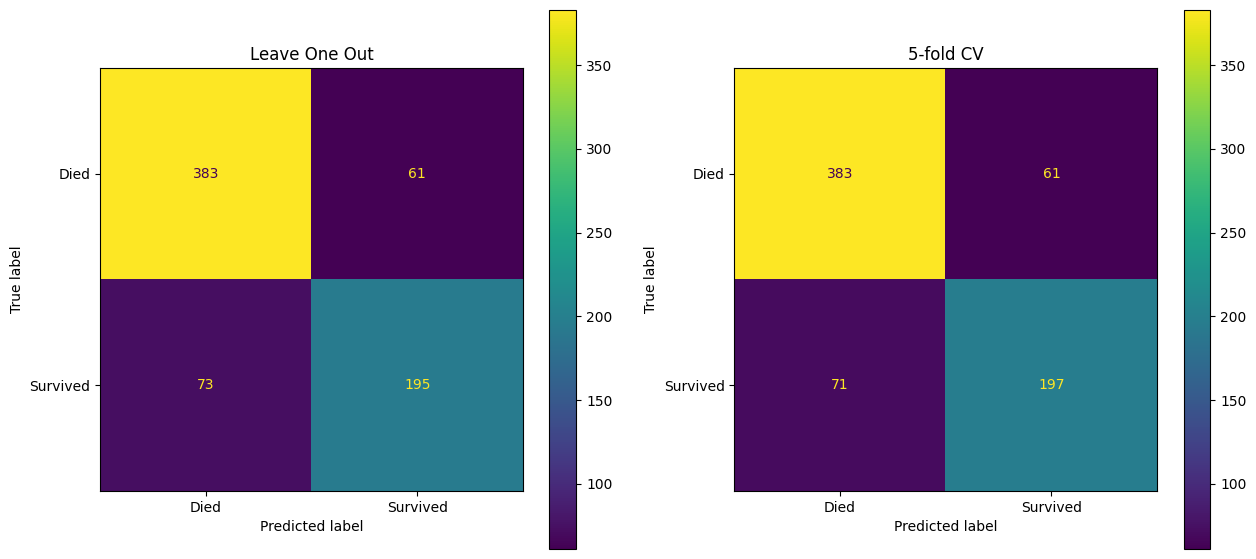

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

confusion_matrix_10 = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_true=y_train_val,
        y_pred=y_pred_leave_one_out
        ),
        display_labels=["Died", "Survived"]

)

confusion_matrix_10.plot(ax=ax1)
ax1.set_title("Leave One Out")

confusion_matrix_5 = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_true=y_train_val,
        y_pred=y_pred_5
        ),
        display_labels=["Died", "Survived"]

)

confusion_matrix_5.plot(ax=ax2)
ax2.set_title("5-fold CV")

We can also generate other reports here.

In [21]:
pd.DataFrame(
    classification_report(y_train_val, y_pred_leave_one_out,
                          output_dict=True)
)

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.839912,0.761719,0.811798,0.800816,0.810480
recall,0.862613,0.727612,0.811798,0.795112,0.811798
f1-score,0.851111,0.744275,0.811798,0.797693,0.810897
support,444.000000,268.000000,0.811798,712.000000,712.000000
